In [1]:
import os
import cv2
import numpy as np
import pickle

# Load dataset paths
train_image_path = "Data/train/image/"
train_mask_path = "Data/train/mask/"

train_images = sorted(os.listdir(train_image_path))
mask_images = sorted(os.listdir(train_mask_path))

train_data = []  # To store pixel-wise features

for img_file, mask_file in zip(train_images, mask_images):
    img = cv2.imread(os.path.join(train_image_path, img_file), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(train_mask_path, mask_file), cv2.IMREAD_GRAYSCALE)

    # Resize to 512x512
    img = cv2.resize(img, (512, 512))
    mask = cv2.resize(mask, (512, 512))

    # Normalize values (0 to 1)
    img = img / 255.0
    mask = mask / 255.0

    # Flatten and stack pixel-wise features
    img_flat = img.flatten()
    mask_flat = mask.flatten()
    
    combined_features = np.column_stack((img_flat, mask_flat))  # Shape: (262144, 2)
    train_data.append(combined_features)

# Convert to NumPy array
train_data = np.vstack(train_data)  # Shape: (num_pixels * num_images, 2)

print(f"Training Data Shape: {train_data.shape}")

# Save preprocessed data
np.save("train_data.npy", train_data)
print("Preprocessed data saved successfully.")


Training Data Shape: (20971520, 2)
Preprocessed data saved successfully.


In [2]:
from sklearn.decomposition import PCA
import numpy as np
import pickle

# Load training data
train_data = np.load("train_data.npy")  # Shape: (num_pixels * num_images, 2)

# **Apply PCA with a valid number of components**
num_components = 1  # Must be ≤ min(n_samples, n_features)
pca = PCA(n_components=num_components)
train_pca = pca.fit_transform(train_data)  # Shape: (num_samples, 1)

print(f"PCA Applied. Transformed Shape: {train_pca.shape}")

# Save PCA model and transformed data
pickle.dump(pca, open("pca_model.pkl", "wb"))
np.save("train_pca.npy", train_pca)

print("✅ PCA model and transformed data saved successfully.")


PCA Applied. Transformed Shape: (20971520, 1)
✅ PCA model and transformed data saved successfully.


In [3]:
from sklearn.cluster import KMeans

# Load PCA-transformed data
train_pca = np.load("train_pca.npy")

# Train K-Means with 3 clusters (Blood Vessels, Retina, Background)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(train_pca)

print("K-Means trained with 3 clusters and saved successfully!")

# Save the trained K-Means model
pickle.dump(kmeans, open("kmeans_model.pkl", "wb"))


K-Means trained with 3 clusters and saved successfully!


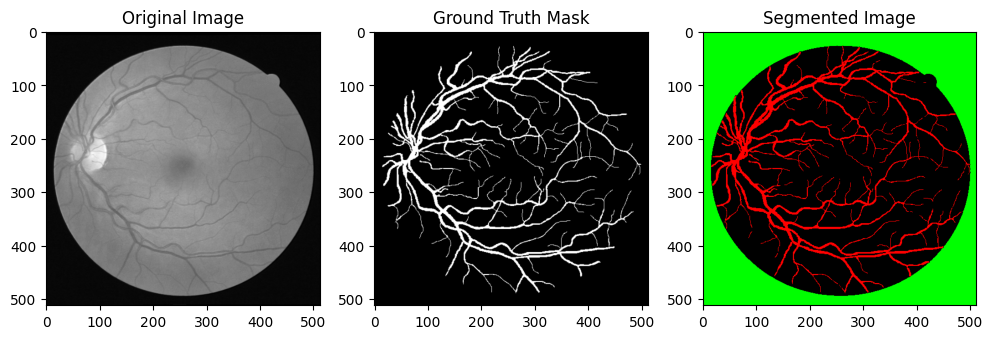

In [4]:
import matplotlib.pyplot as plt

# Load trained PCA and K-Means
pca = pickle.load(open("pca_model.pkl", "rb"))
kmeans = pickle.load(open("kmeans_model.pkl", "rb"))

# Load test image and mask
test_image_path = "Data/test/image/"
test_mask_path = "Data/test/mask/"

test_files = sorted(os.listdir(test_image_path))
mask_files = sorted(os.listdir(test_mask_path))

# Pick the first test image & mask
test_img = cv2.imread(os.path.join(test_image_path, test_files[0]), cv2.IMREAD_GRAYSCALE)
test_mask = cv2.imread(os.path.join(test_mask_path, mask_files[0]), cv2.IMREAD_GRAYSCALE)

# Resize to 512x512
test_img = cv2.resize(test_img, (512, 512))
test_mask = cv2.resize(test_mask, (512, 512))

# Normalize pixel values
test_img = test_img / 255.0
test_mask = test_mask / 255.0

# Flatten images
test_flat = test_img.flatten()  # (262144,)
mask_flat = test_mask.flatten()  # (262144,)

# Combine features for PCA
test_features = np.column_stack((test_flat, mask_flat))  # Shape: (262144, 2)

# Apply PCA transformation
test_pca = pca.transform(test_features)  # Shape: (262144, 10)

# Predict segmentation labels
labels = kmeans.predict(test_pca)  # Shape: (262144,)

# Reshape labels back to image dimensions
segmented_reshaped = labels.reshape(512, 512)

# Identify clusters
unique_clusters, counts = np.unique(segmented_reshaped, return_counts=True)
background_cluster = unique_clusters[np.argmax(counts)]  # Most common → Background
blood_vessel_cluster = unique_clusters[np.argmin(counts)]  # Least common → Blood Vessels
retina_cluster = 3 - (background_cluster + blood_vessel_cluster)

# Map clusters to colors
segmented_final = np.zeros((512, 512, 3), dtype=np.uint8)  # RGB image

segmented_final[segmented_reshaped == blood_vessel_cluster] = [255, 0, 0]  # Blood Vessels → Red
segmented_final[segmented_reshaped == retina_cluster] = [0, 255, 0]  # Retina → Green
segmented_final[segmented_reshaped == background_cluster] = [0, 0, 0]  # Background → Black

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(test_img, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(test_mask, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Segmented Image")
plt.imshow(segmented_final)  # RGB visualization

plt.show()


Check on all the images

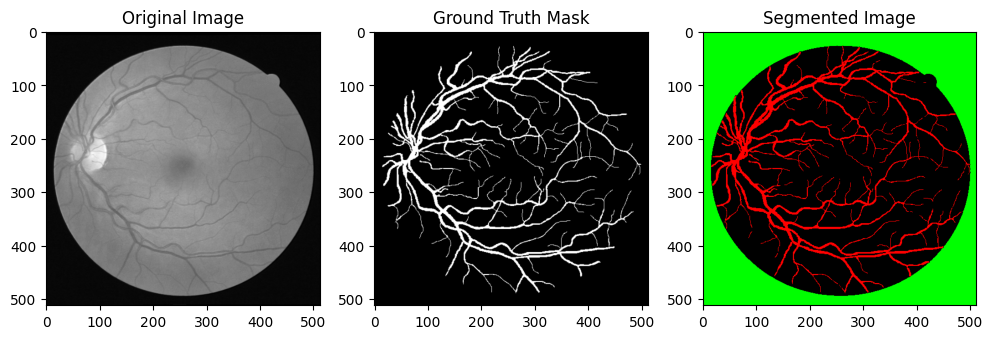

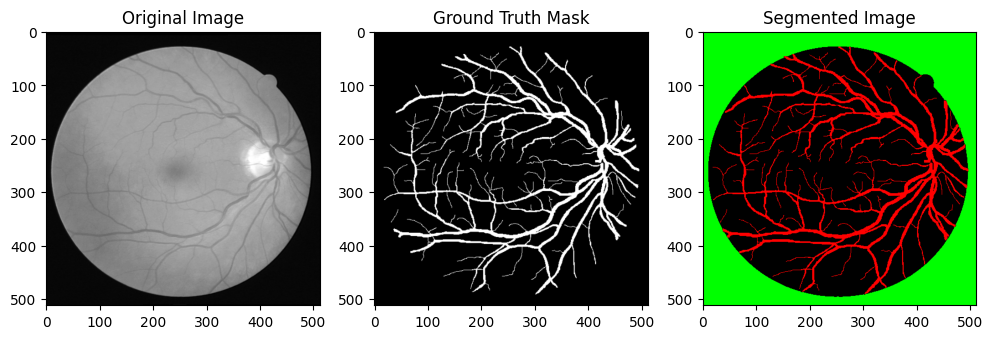

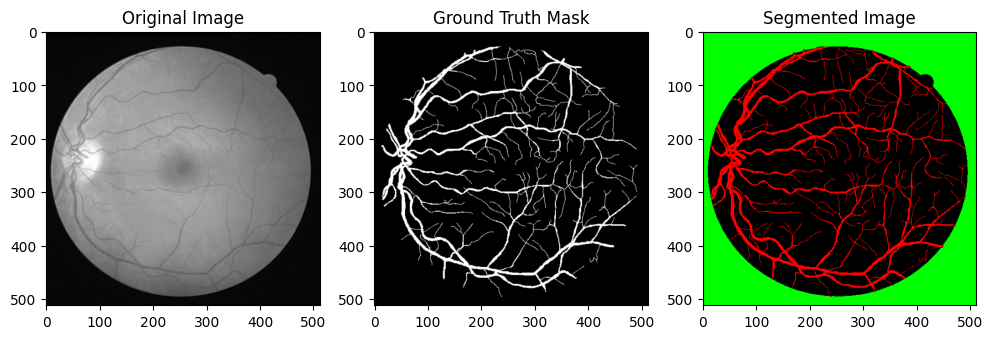

In [5]:
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Load trained PCA and K-Means
pca = pickle.load(open("pca_model.pkl", "rb"))
kmeans = pickle.load(open("kmeans_model.pkl", "rb"))

# Load test image and mask
test_image_path = "Data/test/image/"
test_mask_path = "Data/test/mask/"

test_files = sorted(os.listdir(test_image_path))
mask_files = sorted(os.listdir(test_mask_path))

# Create output directory for segmented images if it doesn't exist
output_dir = "segmented_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through all test images
for i in range(len(test_files)):
    # Pick the test image & mask
    test_img = cv2.imread(os.path.join(test_image_path, test_files[i]), cv2.IMREAD_GRAYSCALE)
    test_mask = cv2.imread(os.path.join(test_mask_path, mask_files[i]), cv2.IMREAD_GRAYSCALE)

    # Resize to 512x512
    test_img = cv2.resize(test_img, (512, 512))
    test_mask = cv2.resize(test_mask, (512, 512))

    # Normalize pixel values
    test_img = test_img / 255.0
    test_mask = test_mask / 255.0

    # Flatten images
    test_flat = test_img.flatten()  # (262144,)
    mask_flat = test_mask.flatten()  # (262144,)

    # Combine features for PCA
    test_features = np.column_stack((test_flat, mask_flat))  # Shape: (262144, 2)

    # Apply PCA transformation
    test_pca = pca.transform(test_features)  # Shape: (262144, 10)

    # Predict segmentation labels
    labels = kmeans.predict(test_pca)  # Shape: (262144,)

    # Reshape labels back to image dimensions
    segmented_reshaped = labels.reshape(512, 512)

    # Identify clusters
    unique_clusters, counts = np.unique(segmented_reshaped, return_counts=True)
    background_cluster = unique_clusters[np.argmax(counts)]  # Most common → Background
    blood_vessel_cluster = unique_clusters[np.argmin(counts)]  # Least common → Blood Vessels
    retina_cluster = 3 - (background_cluster + blood_vessel_cluster)

    # Map clusters to colors
    segmented_final = np.zeros((512, 512, 3), dtype=np.uint8)  # RGB image

    segmented_final[segmented_reshaped == blood_vessel_cluster] = [255, 0, 0]  # Blood Vessels → Red
    segmented_final[segmented_reshaped == retina_cluster] = [0, 255, 0]  # Retina → Green
    segmented_final[segmented_reshaped == background_cluster] = [0, 0, 0]  # Background → Black

    # Save segmented image to output folder
    output_path = os.path.join(output_dir, f"segmented_{test_files[i]}")
    cv2.imwrite(output_path, segmented_final)  # Save as an image

    # Optionally, display results for the first few images (remove if not needed)
    if i < 3:  # Display the first 3 images for quick checking
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(test_img, cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(test_mask, cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title("Segmented Image")
        plt.imshow(segmented_final)  # RGB visualization

        plt.show()


In [6]:
import os
import cv2
import numpy as np
import pickle
from sklearn.metrics import jaccard_score

# Load trained PCA and K-Means
pca = pickle.load(open("pca_model.pkl", "rb"))
kmeans = pickle.load(open("kmeans_model.pkl", "rb"))

# Load test image and mask paths
test_image_path = "Data/test/image/"
test_mask_path = "Data/test/mask/"

test_files = sorted(os.listdir(test_image_path))
mask_files = sorted(os.listdir(test_mask_path))

# Create output directory for segmented images if it doesn't exist
output_dir = "segmented_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Accuracy metrics storage
iou_scores = []

# Function to compute IoU
def compute_iou(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / union if union != 0 else 0

# Loop through all test images
for i in range(len(test_files)):
    # Load and preprocess test image & mask
    test_img = cv2.imread(os.path.join(test_image_path, test_files[i]), cv2.IMREAD_GRAYSCALE)
    test_mask = cv2.imread(os.path.join(test_mask_path, mask_files[i]), cv2.IMREAD_GRAYSCALE)

    test_img = cv2.resize(test_img, (512, 512)) / 255.0
    test_mask = cv2.resize(test_mask, (512, 512)) / 255.0

    # Flatten images and apply PCA transformation
    test_features = np.column_stack((test_img.flatten(), test_mask.flatten()))
    test_pca = pca.transform(test_features)

    # Predict segmentation labels
    labels = kmeans.predict(test_pca).reshape(512, 512)

    # Identify clusters
    unique_clusters, counts = np.unique(labels, return_counts=True)
    background_cluster = unique_clusters[np.argmax(counts)]
    blood_vessel_cluster = unique_clusters[np.argmin(counts)]
    retina_cluster = 3 - (background_cluster + blood_vessel_cluster)

    # Generate segmented output
    segmented_final = np.zeros((512, 512, 3), dtype=np.uint8)
    segmented_final[labels == blood_vessel_cluster] = [255, 0, 0]  # Blood Vessels → Red
    segmented_final[labels == retina_cluster] = [0, 255, 0]  # Retina → Green
    segmented_final[labels == background_cluster] = [0, 0, 0]  # Background → Black

    # Save segmented image
    cv2.imwrite(os.path.join(output_dir, f"segmented_{test_files[i]}"), segmented_final)

    # Compute IoU
    pred_mask = (labels == blood_vessel_cluster).astype(int)
    iou_scores.append(compute_iou(pred_mask, test_mask))

# Print final model performance summary
print("Model Performance:-")
print(f"Average IoU Score: {np.mean(iou_scores):.4f}")


Model Performance:-
Average IoU Score: 0.7346
